In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from datetime import datetime
from jupyterthemes import jtplot
jtplot.style()
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from datetime import datetime, timedelta

In [2]:
np.random.seed(123)
tf.random.set_seed(123)

Extracting the data from yahoo finance

In [3]:
# SP500 data 
end=datetime.now()
stock=yf.download('^GSPC','2012-01-01',end)

[*********************100%***********************]  1 of 1 completed


In [4]:
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,3958.689941,3958.909912,3901.270020,3916.639893,3916.639893,9354280000
2023-03-20,3917.469971,3956.620117,3916.889893,3951.570068,3951.570068,5347140000
2023-03-21,3975.889893,4009.080078,3971.189941,4002.870117,4002.870117,4920240000
2023-03-22,4002.040039,4039.489990,3936.169922,3936.969971,3936.969971,4533010000
2023-03-23,3959.209961,4007.659912,3919.050049,3948.719971,3948.719971,4991600000


<Figure size 1500x1000 with 0 Axes>

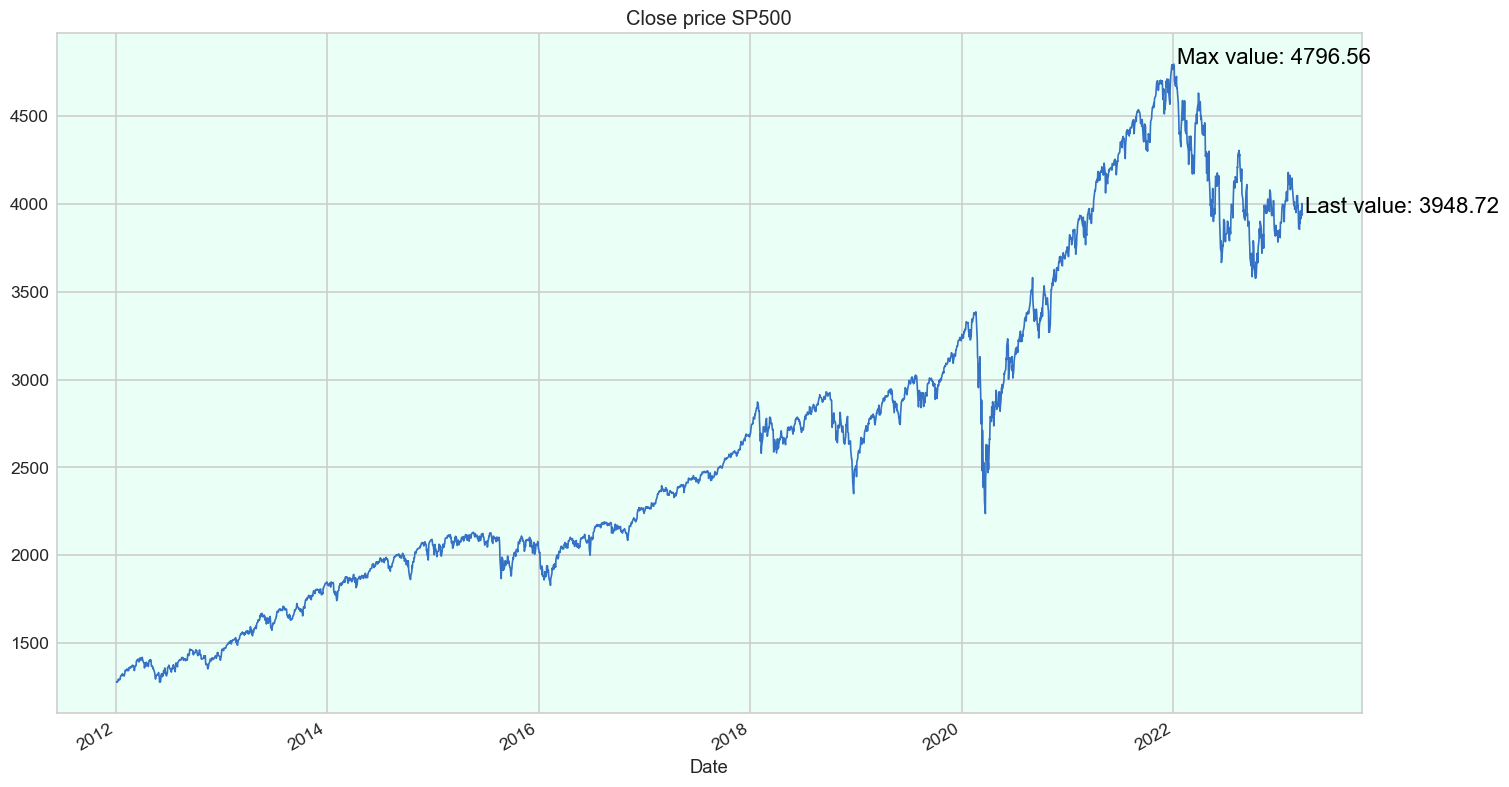

In [19]:
# The data is plotted to observe trends or strange values
jtplot.style()
plt.figure(figsize=(15, 10))
fig,ax=plt.subplots(figsize=(15,10))
stock['Close'].plot()
max_value=stock['Close'].max()
max_index=stock['Close'].idxmax()
last_value=stock['Close'][-1]
last_index=stock['Close'].tail(1).idxmax()
ax.set_title('Close price SP500')
ax.annotate(f'Max value: {max_value:.2f}', 
            xy=(max_index, max_value),
            xytext=(max_index + np.timedelta64(10, 'D'), max_value -1), 
            arrowprops=dict(facecolor='blue', arrowstyle='->'),
            fontsize=16,color='black')
ax.annotate(f'Last value: {last_value:.2f}', 
            xy=(last_index, last_value),
            xytext=(last_index + np.timedelta64(10, 'D'), last_value -1), 
            arrowprops=dict(facecolor='blue', arrowstyle='->'),
            fontsize=16,color='black')
ax.set_facecolor('#eafff5')

plt.show()

In [6]:
stock.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
#Only the Close column is selected
stock_close_1=stock.filter(['Close'])
stock_close_1

,Close
Date,
2012-01-03,1277.060059
2012-01-04,1277.300049
2012-01-05,1281.060059
2012-01-06,1277.810059
2012-01-09,1280.699951
...,...
2023-03-17,3916.639893
2023-03-20,3951.570068
2023-03-21,4002.870117


In [8]:
stock_close=stock_close_1.values
#The data is divided into training and valid
training_data_len = int(np.ceil( len(stock_close) * .80 ))
dif_len=len(stock_close)-training_data_len
dif_len

564

In [9]:
# The data is scaled to normalize the values and also to avoid a large effect of outliers.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_close)

In [10]:
# Creating the training data set 
train_data = scaled_data[0:int(training_data_len), :]
train_data

array([[0.00000000e+00],
       [6.81887298e-05],
       [1.13652507e-03],
       ...,
       [6.86989590e-01],
       [6.84813170e-01],
       [6.85594531e-01]])

In [11]:
# Split the data into x_train and y_train data 
x_train = []
y_train = []

for i in range(dif_len, len(train_data)):
    x_train.append(train_data[i-dif_len:i, 0])
    y_train.append(train_data[i, 0])
    
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1696/1696 [==============================] - 371s 216ms/step - loss: 7.4125e-04


In [13]:
# Create the testing data set
test_data = scaled_data[training_data_len - dif_len: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = stock_close[training_data_len:, :]
for i in range(dif_len, len(test_data)):
    x_test.append(test_data[i-dif_len:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [14]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

18/18 [==============================] - 5s 223ms/step


85.76150025162734

In [15]:
# Plot the data
valid = stock_close_1[training_data_len:]
valid = pd.DataFrame(valid, columns=['Close'])
valid['Predictions'] = predictions
train = stock_close_1[:training_data_len]

<Figure size 1500x1000 with 0 Axes>

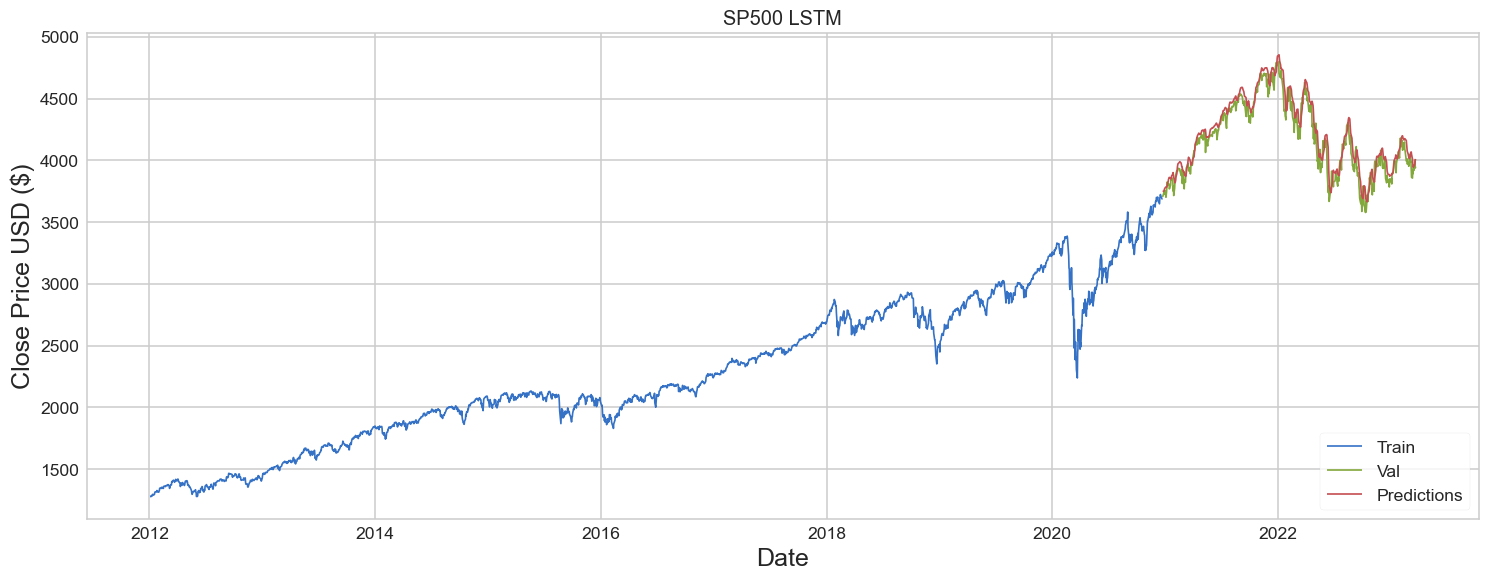

In [20]:
# Visualize the data
jtplot.style()
plt.figure(figsize=(15, 10))
plt.figure(figsize=(16,6))
plt.title('SP500 LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<Figure size 1500x1000 with 0 Axes>

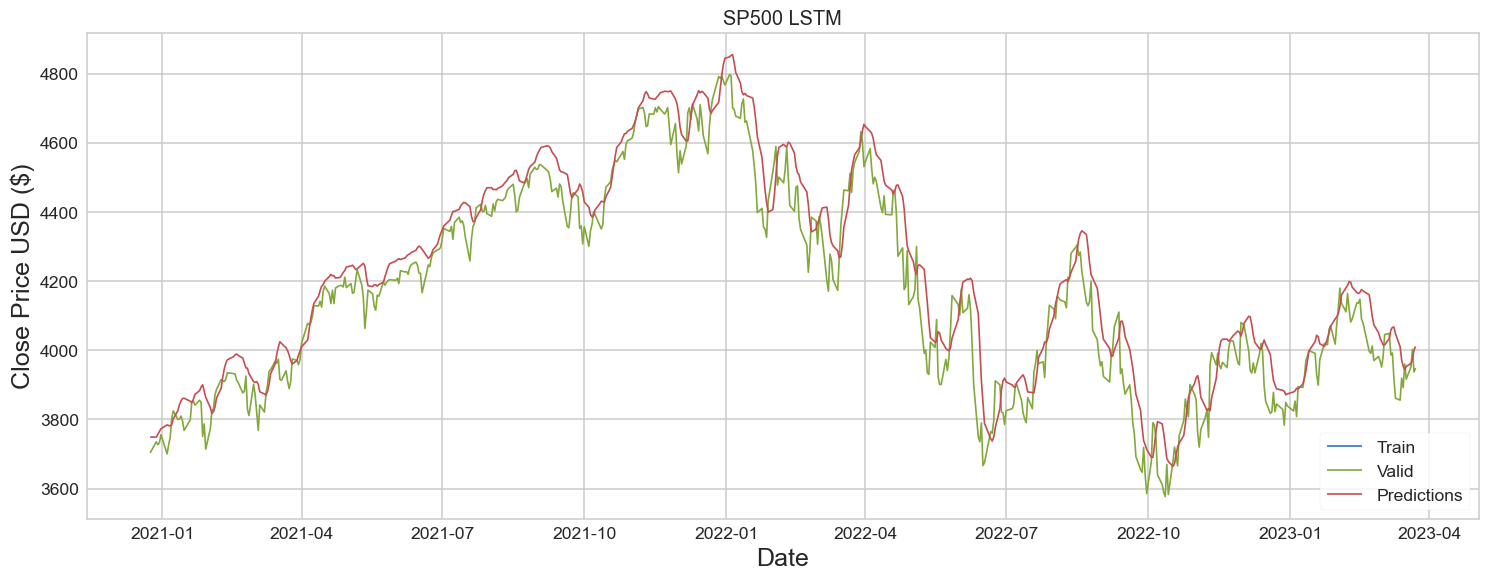

In [42]:
# Visualize the data
jtplot.style()
plt.figure(figsize=(15, 10))
plt.figure(figsize=(16,6))
plt.title('SP500 LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][2300:])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

Tomorrow's stock prediction

In [43]:
#Get the latest "dif_len" normalized closing prices
last_dif_len_prices = scaled_data[-dif_len:]

x = np.array([last_dif_len_prices])

# Prediction using the neural network model
prediction_tomorrow = model.predict(x)

# Denormalize the prediction to obtain the value of the action
predicted_price_tomorrow = scaler.inverse_transform(prediction_tomorrow)[0][0]
print(f'The predicted price for tomorrow {datetime.now().strftime("%Y-%m-%d")} is {predicted_price_tomorrow} ')

1/1 [==============================] - 0s 48ms/step
The predicted price for tomorrow 2023-03-24 is 4015.250244140625 
